this script is for visualizing the results from the case study

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive
from src.nucleolus import get_nucleolus
from src.least_core_nucleolus import get_least_core_nucleolus

In [3]:
def make_game_superadditive(v: dict, players: list) -> dict:
    """
    make game superadditive by adjusting values of coalitions

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    """
    v_superadd = v.copy()
    for S in powerset(players, exclude_empty=True):
        T = frozenset(players) - S
        union = S.union(T)
        if v_superadd[union] < v_superadd[S] + v_superadd[T]:
            v_superadd[union] = v_superadd[S] + v_superadd[T]
    return v_superadd

In [4]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_32668\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [5]:
services = ['FFR-FCR']  # list of services to visualize
dvpps_infos = {}  # dictionary to hold dvpp info dataframes
main_paths = ['pics/v_case_0604/', 'pics/v_case_0704/', 'pics/v_case/']
main_path = 'pics/v_case_combined/'
df_expected = pd.DataFrame()
df_realized = pd.DataFrame()
dvpp_info = pd.DataFrame()
df_bids = pd.DataFrame()

df_expected = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
for service in services:
    dvpps_infos[service] = pd.read_csv(f'{main_path}dvpp_info_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

## option to merge folders

In [6]:
# # quicklt merge the files in v_case
# for main_path in main_paths:
#     df_expected_tmp = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
#     # df_expected_tmp.columns = [tuple(c for c in col if c!='nan') for col in df_expected_tmp.columns.values]
#     df_realized_tmp = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
#     # df_realized_tmp.columns = [tuple(c for c in col if c!='nan') for col in df_realized_tmp.columns.values]
#     df_expected = pd.concat([df_expected, df_expected_tmp])
#     df_realized = pd.concat([df_realized, df_realized_tmp])
#     # also do for dvpp_info_DPF_FFR-FCR
#     dvpp_info_tmp = pd.read_csv(f'{main_path}dvpp_info_DPF_FFR-FCR.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     dvpp_info = pd.concat([dvpp_info, dvpp_info_tmp])
#     # also for bids
#     # df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     df_bids_tmp = pd.read_csv(f'{main_path}bids_DPF_FFR-FCR.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')
#     df_bids = pd.concat([df_bids, df_bids_tmp])

In [7]:
# # change index for df_expected
# new_index = pd.MultiIndex.from_product((['FFR-FCR'], np.arange(len(df_expected))))
# df_expected.index = new_index
# df_realized.index = new_index

In [8]:
# # save in folder
# main_path = 'pics/v_case_combined/'
# df_expected.to_csv(f'{main_path}expected_values_DPF.csv')
# df_realized.to_csv(f'{main_path}values_DPF.csv')
# dvpp_info.to_csv(f'{main_path}dvpp_info_DPF_FFR-FCR.csv')
# df_bids.to_csv(f'{main_path}bids_DPF_FFR-FCR.csv')

# Reward Split

## Pure-Nucleolus Reward Split

In [9]:
# get reward split of devices
players = [c[0] for c in df_expected.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_expected.index.get_level_values(1), ['E-Value', 'E-Nucleolus', 'R-Value', 'R-Nucleolus']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
for idx, row in df_expected.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    if game_is_superadditive(v, players):
        superadditivity_counter += 1
        nucleolus = get_nucleolus(v, players)
    else:
        print(f"for time {idx[0]}, expected game is not superadditive.")
        print(v)
        nucleolus = get_least_core_nucleolus(v, players)
    if is_convex_game(v, players):
        convexity_counter += 1
    if core_nonempty(v, players):
        core_non_empty_counter += 1
    df_reward_split.loc[(idx[1], 'E-Nucleolus'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
    df_reward_split.loc[(idx[1], 'E-Value'), list(p for p in players)] = [v[frozenset({p})] for p in players]
    # 2. Realized game convert to dictionary
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    nucleolus_realized = get_least_core_nucleolus(v_realized, players)
    df_reward_split.loc[(idx[1], 'R-Nucleolus'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
    df_reward_split.loc[(idx[1], 'R-Value'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 1.08426, frozenset({'Wind'}): 1.19386, frozenset({'BESS'}): 0.0, frozenset({'Wind', 'PV'}): 2.23926, frozenset({'BESS', 'PV'}): 2.72833, frozenset({'Wind', 'BESS'}): 3.73485, frozenset({'BESS', 'Wind', 'PV'}): 6.60369, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 0.30697, frozenset({'Wind'}): 0.06578, frozenset({'BESS'}): 0.0, frozenset({'Wind', 'PV'}): 0.36636, frozenset({'BESS', 'PV'}): 0.77242, frozenset({'Wind', 'BESS'}): 0.20578, frozenset({'BESS', 'Wind', 'PV'}): 1.02185, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 1.4768, frozenset({'Wind'}): 0.05355, frozenset({'BESS'}): 0.0, frozenset({'Wind', 'PV'}): 1.40456, frozenset({'BESS', 'PV'}): 3.71608, frozenset({'Wind', 'BESS'}): 0.16098, frozenset({'BESS', 'Wind', 'PV'}): 3.71608, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'P

In [10]:
print(f"For {main_path}, out of {len(df_expected)} games, {superadditivity_counter} superadditive, {convexity_counter} convex and {core_non_empty_counter} non-empty core.") 

For pics/v_case_combined/, out of 163 games, 106 superadditive, 80 convex and 135 non-empty core.


# Reward Split with New Method

In [11]:
from src.game_theory_helpers import evaluate_full_game, solve_optimal_partition

In [12]:
df_rewards = evaluate_full_game(df_expected, df_realized)

In [13]:
hours = df_rewards.index.get_level_values(0).unique()
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method'].value_counts())
print(f"out of {len(hours)}.")

Method
Shapley      80
Nucleolus    55
Sub-Game     28
Name: count, dtype: int64
out of 163.


In [14]:
# also show realized game
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method-Realized'].value_counts())
print(f"out of {len(hours)}.")

Method-Realized
Shapley      69
Sub-Game     63
Nucleolus    31
Name: count, dtype: int64
out of 163.


In [15]:
# new multiindex
idxs1 = df_rewards.index.get_level_values(0).unique().values
idxs2 = df_rewards.index.get_level_values(1).unique().values
idxs3 = df_rewards.index.get_level_values(2).unique().values
idxs2_new = []
for i in idxs2:
    # append idx3
    for j in idxs3:
        idxs2_new.append(f'{i}-{j}')

In [16]:
df_rewards.index = pd.MultiIndex.from_product([idxs1, idxs2_new])

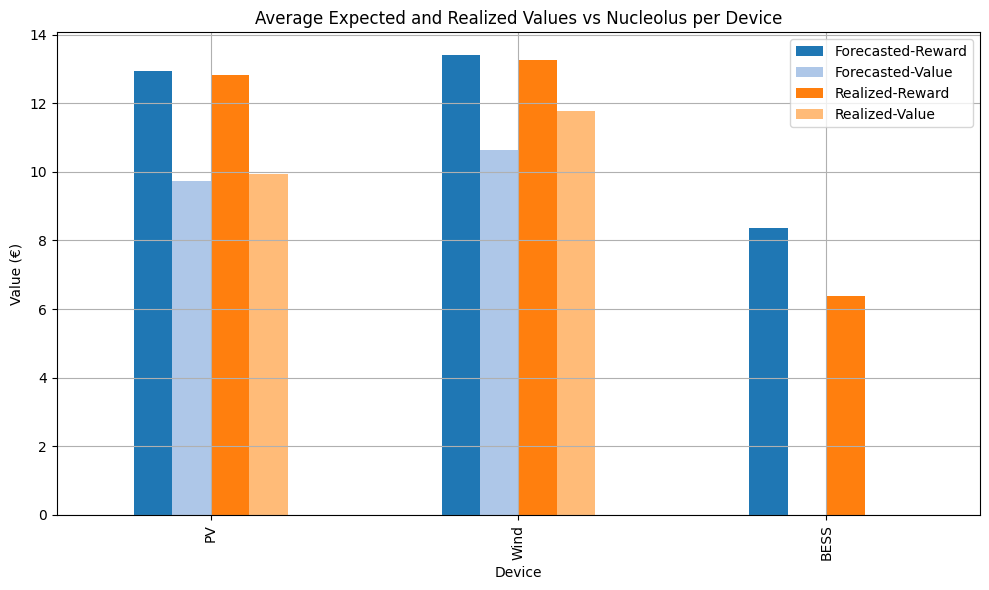

In [17]:
# plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))

devices = ['PV', 'Wind', 'BESS']
df_plot = df_rewards[devices]
df_mean = df_plot.groupby(level=1).mean()
df_mean = df_mean.transpose()
df_mean.plot.bar(ax=ax)

ax.set_title('Average Expected and Realized Values vs Nucleolus per Device')
ax.set_ylabel('Value (€)')
ax.set_xlabel('Device')
ax.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [18]:
import seaborn as sns

In [19]:
from scipy import stats
import numpy as np
import pandas as pd

def assess_distribution_fit(data, distributions_to_test):
    """
    Fits and compares distributions using the Maximum Likelihood Estimation 
    (MLE) for fitting and the Kolmogorov-Smirnov (KS) test for scoring.
    """
    results = []
    
    # 💡 The list of distributions you want to check
    # Other common choices: 'weibull_min', 'lognorm', 'gamma', 'beta'
    
    for dist_name in distributions_to_test:
        dist = getattr(stats, dist_name)
        
        try:
            # 1. Fit the parameters using Maximum Likelihood Estimation (MLE)
            params = dist.fit(data)
            
            # 2. Perform the KS test to compare the data to the fitted distribution
            # H0: The data comes from the specified distribution
            ks_stat, p_value = stats.kstest(data, dist_name, args=params)
            
            results.append({
                'Distribution': dist_name,
                'KS Statistic': ks_stat, # Lower is better
                'P-Value': p_value      # Higher (ideally > 0.05) is better
            })
        except Exception:
            # Catch distributions that might fail to converge on parameters
            results.append({'Distribution': dist_name, 'KS Statistic': np.nan, 'P-Value': np.nan})
            
    # Sort by the KS Statistic to find the best fit quickly
    df = pd.DataFrame(results).sort_values(by='KS Statistic', ascending=True)
    
    # 
    
    return df

# Example Usage (Use your actual data instead of this random sample)
data = np.random.normal(loc=5, scale=1.5, size=100)
test_dists = ['norm', 't', 'laplace', 'expon']

fit_results = assess_distribution_fit(data, test_dists)
print(fit_results)

  Distribution  KS Statistic   P-Value
1            t      0.056751  0.885831
0         norm      0.056753  0.885813
2      laplace      0.101022  0.242385
3        expon      0.258075  0.000002


In [20]:
4253 / (4253 + 1406)

0.7515462095776639

For Forecasted-Value, 2369.4 values above 20, 951.4 values below or equal to 20.
For Forecasted-Value, 45 counts above 20, 444 counts below or equal to 20.
For Forecasted-Reward, 4253.0 values above 20, 1406.5 values below or equal to 20.
For Forecasted-Reward, 86 counts above 20, 403 counts below or equal to 20.
For Realized-Value, 3333.0 values above 20, 943.9 values below or equal to 20.
For Realized-Value, 58 counts above 20, 412 counts below or equal to 20.
For Realized-Reward, 4715.4 values above 20, 1339.7 values below or equal to 20.
For Realized-Reward, 89 counts above 20, 375 counts below or equal to 20.


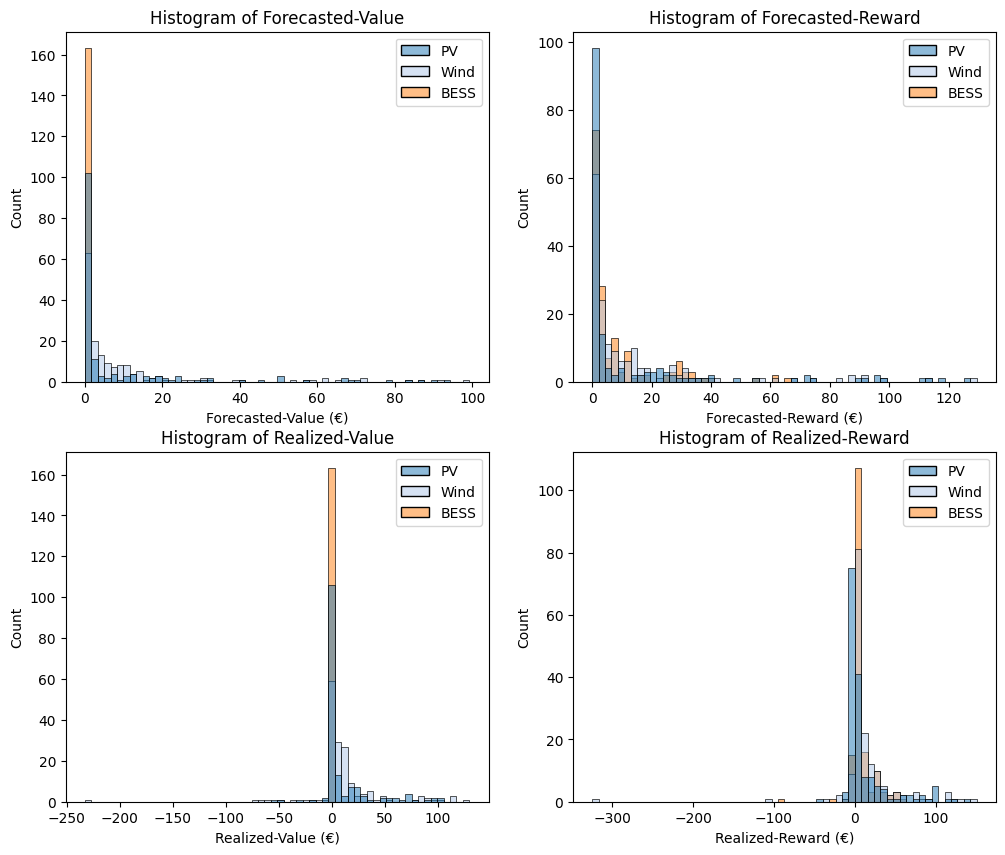

In [21]:
# make 4 subplots axis
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, x in enumerate(df_plot.index.get_level_values(1).unique().values):
    sns.histplot(df_plot.loc(axis=0)[:, x], bins=60, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Histogram of {x}')
    axs[i//2, i%2].set_xlabel(f'{x} (€)')
    
    # fit_results = assess_distribution_fit([x for xs in df_plot.loc(axis=0)[:, x].values for x in xs], test_dists)
    # print(fit_results)
    # print the numer of values above
    vals = [x for xs in df_plot.loc(axis=0)[:, x].values for x in xs]
    thresh = 20
    above_thresh, above_count = sum(v for v in vals if v > thresh), sum(1 for v in vals if v > thresh)
    below_thresh, below_count = sum(v for v in vals if 0 <= v <= thresh), sum(1 for v in vals if 0 <= v <= thresh)
    print(f'For {x}, {above_thresh:.1f} values above {thresh}, {below_thresh:.1f} values below or equal to {thresh}.')
    print(f'For {x}, {above_count} counts above {thresh}, {below_count} counts below or equal to {thresh}.')

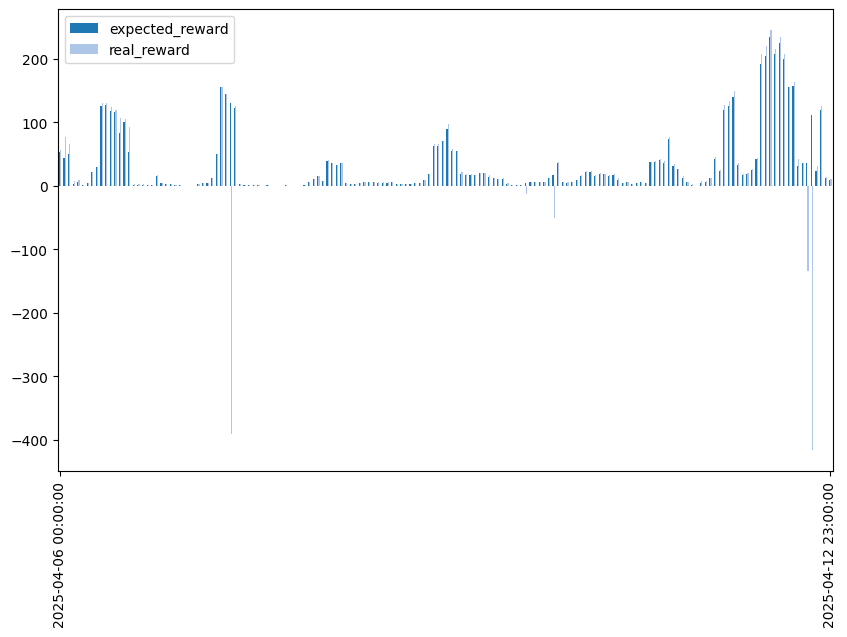

In [22]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
# df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))
# set x axis labels as only start and end time and 5 time points in between
plt.xticks([0, len(df_exp_real)-1], [df_exp_real.index[0], df_exp_real.index[-1]])
plt.show()

### Analyze the Sub-game cases

In [23]:
from src.get_optimal_bid import get_optimal_bid
import numpy as np

In [24]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")
# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]
# Create extended cycle: first full alpha, then alpha=0.5
# colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]
# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_32668\216728504.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [25]:
# load bids dataframe
df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

In [26]:
idxs_sg = df_rewards[df_rewards['Method']=='Sub-Game'].index.get_level_values(0).unique()

In [27]:
idxs_sg

Index([  6,  30,  34,  35,  44,  50,  54,  55,  71,  74,  76,  78,  81,  83,
        97, 102, 104, 118, 120, 122, 123, 126, 128, 129, 147, 148, 149, 150],
      dtype='int64')

In [28]:
def map_idx_to_datetime(idx):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    return pd.Timestamp(vals[idx])
def map_datetime_to_idx(dt):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    for i, v in enumerate(vals):
        if v == dt:
            return i
    return None

In [29]:
def bid_value(bids, rho, bid,
              return_prob=False):
    gamma = sum(rho for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [30]:
def bids_to_values(bids, rho, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rho, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rho, b, return_prob=True) for b in bids])
        return gammas, values

In [31]:
dt_idxs = [map_idx_to_datetime(i) for i in idxs_sg]

In [32]:
cols = df_bids.columns
idx_tuples = [eval(col) for col in df_bids.columns.values]
idx_frozensets = [frozenset(tup) for tup in idx_tuples]
the_map = {fs: col for fs, col in zip(idx_frozensets, cols)}

In [40]:
3 / 20

0.15

C:\Users\pasca\AppData\Local\Temp\ipykernel_32668\2374140084.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-06 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 3.76963.
Coalition frozenset({'Wind'}) max value at index 3, bid: 0.125, value: 0.050
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 3.457, value: 3.457
Coalition frozenset({'BESS', 'Wind', 'PV'}) max value at index 0, bid: 3.457, value: 3.457


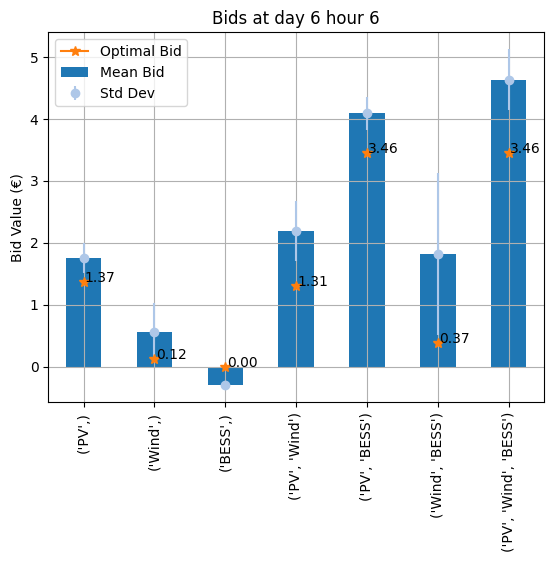

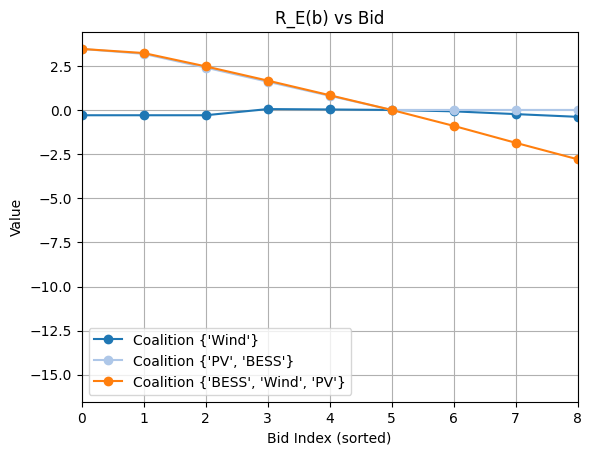

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-07 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 4.2260599999999995.
Coalition frozenset({'Wind'}) max value at index 4, bid: 0.188, value: 0.038
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 4.205, value: 4.205
Coalition frozenset({'BESS', 'Wind', 'PV'}) max value at index 0, bid: 4.317, value: 4.317


C:\Users\pasca\AppData\Local\Temp\ipykernel_32668\2374140084.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


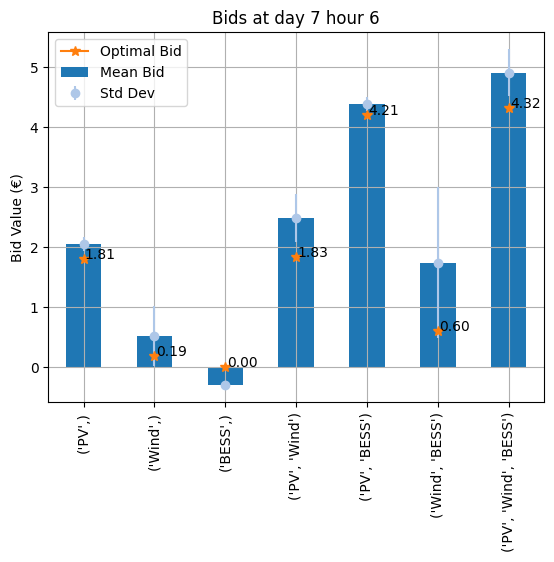

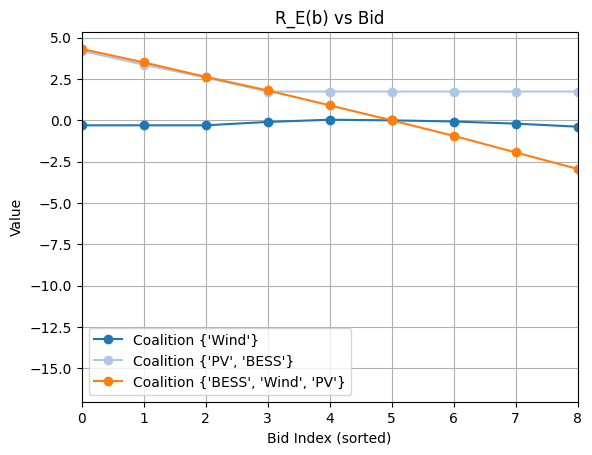

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-07 10:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'PV', 'BESS'})] with value 144.50525.
Coalition frozenset({'Wind'}) max value at index 3, bid: 0.577, value: 0.231
Coalition frozenset({'PV', 'BESS'}) max value at index 0, bid: 5.879, value: 5.879
Coalition frozenset({'BESS', 'Wind', 'PV'}) max value at index 0, bid: 6.255, value: 6.255


C:\Users\pasca\AppData\Local\Temp\ipykernel_32668\2374140084.py:43: PerformanceWarning: indexing past lexsort depth may impact performance.
  the_bids = df_bids.loc[dt, col].values.tolist()


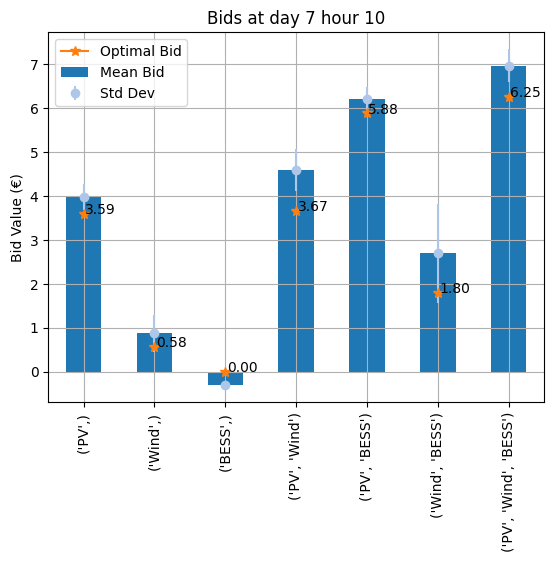

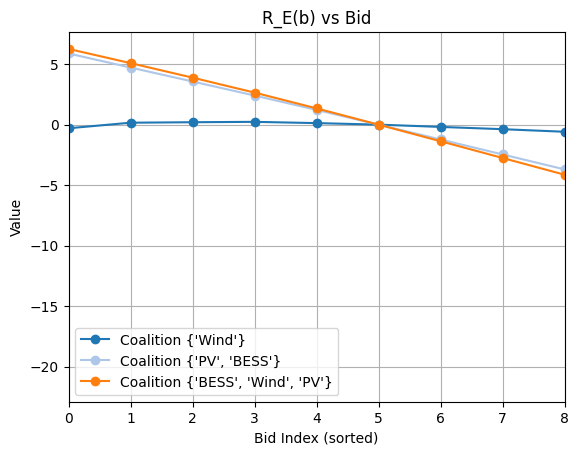

In [33]:
MAX_GAMES_TO_PLOT = 3
dt_idxs = dt_idxs[:MAX_GAMES_TO_PLOT]

K_errors = len(df_bids.loc[dt_idxs[0]])
probs = [1/K_errors for _ in range(K_errors)]
for dt in dt_idxs:
    # print(dvpps_infos[service].loc[dt])
    # visualize mean and std of each column
    plt.figure()
    plt.title(f'Bids at day {dt.day} hour {dt.hour}')
    df_bids.loc[dt].mean(axis=0).plot(kind='bar', label='Mean Bid')
    # plot min max with error bars
    plt.errorbar(x=df_bids.loc[dt].columns, y=df_bids.loc[dt].mean(axis=0), yerr=df_bids.loc[dt].std(axis=0), fmt='o', label='Std Dev',
                 color=base_colors[1])
    # compute optimal bid for each coalition and plot as star marker
    dict_opt_bids = {}
    for coalition in df_bids.loc[dt].columns:
        c_bids = np.squeeze(df_bids.loc[dt, [coalition]].values)
        b_star_coalition, value_wo_price, gamma = get_optimal_bid(c_bids, probs, return_reward=True)
        dict_opt_bids[coalition] = b_star_coalition
        # plot as star marker
        plt.plot(coalition, b_star_coalition, marker='*', markersize=7, label='Optimal Bid' if coalition==df_bids.loc[dt].columns[0] else "", color=base_colors[2])
        # annotate value of optimal bid to the right of the star
        plt.annotate(f'{b_star_coalition:.2f}', (coalition, b_star_coalition), textcoords="offset points", xytext=(12, 0), ha='center', fontsize=10)
    plt.ylabel('Bid Value (€)')
    plt.grid()
    plt.legend()

    # next, also plot th eindividual bids in line chart for non-superadditiv coalitions
    v = {frozenset(k): val for k, val in df_expected.loc[(service, map_datetime_to_idx(dt))].items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    max_value, coalitions = solve_optimal_partition(v)
    print(f'At hour {dt}, optimal partition is {coalitions} with value {max_value}.')
    # plot line chart for this coalition
    plt.figure()
    x_ks = np.arange(K_errors)
    # add grand coalition
    coalitions.append(frozenset(players))

    for coalition in coalitions:
        # convert to columns
        col = the_map[coalition]
        the_bids = df_bids.loc[dt, col].values.tolist()
        the_bids.sort()
        # the_bids = the_bids[::-1]
        # convert bids to values
        vals = bids_to_values(the_bids, probs[0])
        # indicate dict_opt_bids in plot
        plt.plot(x_ks, vals, marker='o', label=f'Coalition {set(coalition)}')
        # print idx and bid of max value
        max_idx = np.argmax(vals)
        print(f"Coalition {coalition} max value at index {max_idx}, bid: {the_bids[max_idx]:.3f}, value: {vals[max_idx]:.3f}")

    plt.xlabel('Bid Index (sorted)')
    plt.ylabel('Value')
    plt.title('R_E(b) vs Bid')
    plt.grid(True)
    plt.xlim((0, 8))
    plt.legend()
    plt.show()

## Plot Examples for Convex, Non-Empty Core and Sub-Coaltiions

In [34]:
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = 14.9
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = 15
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = 22.1
v[frozenset({'PV', 'Wind', 'BESS'})] = 22.2

In [35]:
# realized game
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = -44.6
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = -45.1
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = -66.3
v[frozenset({'PV', 'Wind', 'BESS'})] = -66.7

In [36]:
is_convex_game(v, ['PV', 'Wind', 'BESS'])

False

In [37]:
get_shapley_value(v, ['PV', 'Wind', 'BESS'])

{'PV': -0.16666666666666854,
 'Wind': -55.71666666666667,
 'BESS': -10.816666666666666}

In [38]:
from src.game_theory_helpers import is_convex_game, game_is_superadditive, core_nonempty

In [39]:
core_nonempty(v, ['PV', 'Wind', 'BESS'])

False